This notebook provide a simple demo of using kmp, where trajectory adaptations towards various desired points in terms of positions and velocities are studied. This code is written by Dr. Yanlong Huang.

### Initializations

In [8]:
# myColors
addpath('../fcts/');

NameError: name 'addpath' is not defined

## Load position and velocity from demos

In [5]:
load('../2Dletters/G.mat');
demoNum=5;                    % number of demos
demo_dt=0.01;                 % time interval of data
demoLen=size(demos{1}.pos,2); % size of each demo;
demo_dura=demoLen*demo_dt;    % time length of each demo
dim=2;                        % dimension of demo

totalNum=0;
for i=1:demoNum        
    for j=1:demoLen
        totalNum=totalNum+1;
        Data(1,totalNum)=j*demo_dt;
        Data(2:dim+1,totalNum)=demos{i}.pos(1:dim,j);
        if j<demoLen
            Data(dim+2:2*dim+1,totalNum)=(demos{i}.pos(1:dim,j+1)-demos{i}.pos(1:dim,j))/demo_dt;
        else 
            Data(dim+2:2*dim+1,totalNum)=Data(dim+2:2*dim+1,totalNum-1);
        end
    end    
end

SyntaxError: invalid syntax (<ipython-input-5-f964415d1ec8>, line 2)

## Extract the reference trajectory

In [6]:
model.nbStates = 8;   # Number of states in the GMM
model.nbVar =1+2*dim; % Number of variables [t,x1,x2,.. vx1,vx2...]
model.dt = 0.005;     % Time step duration
nbData = demo_dura/model.dt; % Length of each trajectory

model = init_GMM_timeBased(Data, model);   
model = EM_GMM(Data, model);   

[DataOut, SigmaOut] = GMR(model, [1:nbData]*model.dt, 1, 2:model.nbVar); %see Eq. (17)-(19)

for i=1:nbData
    refTraj(i).t=i*model.dt;
    refTraj(i).mu=DataOut(:,i);
    refTraj(i).sigma=SigmaOut(:,:,i);
end

SyntaxError: invalid syntax (<ipython-input-6-51573d00ccaa>, line 2)

## KMP parameters and via-points

In [4]:
dt=0.005;
len=demo_dura/dt;
lamda=1; % control mean prediction
kh=6;

%% Set desired points
viaFlag=[1 1 1 1]; % determine which via-points are used

viaNum=4;  
via_time(1)=dt; 
via_point(:,1)=[8 10 -50 0]';  % format:[2D-pos 2D-vel]
via_time(2)=0.25;  
via_point(:,2)=[-1 6 -25 -40]';  
via_time(3)=1.2; 
via_point(:,3)=[8 -4 30 10]';    
via_time(4)=2;
via_point(:,4)=[-3 1 -10 3]'; 

via_var=1E-6*eye(4);  % adaptation precision
via_var(3,3)=1000; 
via_var(4,4)=1000;  % low adaptation precision for velocity

## Update the reference trajectory using desired points

In [5]:
newRef=refTraj;
newLen=len;
for viaIndex=1:viaNum
    if viaFlag(viaIndex)==1       
    [newRef,newLen] = kmp_insertPoint(newRef,newLen,via_time(viaIndex),via_point(:,viaIndex),via_var);
    end
end

%% Prediction using kmp
Kinv = kmp_estimateMatrix_mean(newRef,newLen,kh,lamda,dim); 

for index=1:len 
    t=index*dt;  
    mu=kmp_pred_mean(t,newRef,newLen,kh,Kinv,dim);   
    kmpPredTraj(index).t=index*dt;   
    kmpPredTraj(index).mu=mu;         
end

for i=1:len
    gmr(:,i)=refTraj(i).mu;     % format:[2D-pos 2D-vel]
    kmp(:,i)=kmpPredTraj(i).mu; % format:[2D-pos 2D-vel]
end

## Demonstrations and reference trajectory

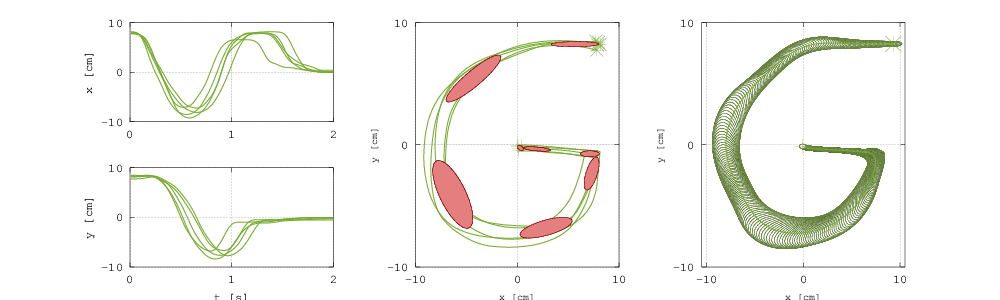

In [30]:
figure('position',[0 0 1000 300]); 

%% show demonstrations
for i=1:demoNum  
    subplot(2,3,1)
    hold on
    plot([demo_dt:demo_dt:demo_dura],Data(2,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
    box on
    ylabel('x [cm]');
    set(gca,'xtick',[0 1 2])
    set(gca,'ytick',[-10 0 10])
    set(gca,'FontSize',12)
    grid on
    set(gca,'gridlinestyle','--')

    subplot(2,3,4)
    hold on
    plot([demo_dt:demo_dt:demo_dura],Data(3,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
    box on
    xlabel('t [s]','interpreter','tex');
    ylabel('y [cm]','interpreter','tex');
    set(gca,'xtick',[0 1 2])
    set(gca,'ytick',[-10 0 10])
    set(gca,'FontSize',12)
    grid on
    set(gca,'gridlinestyle','--')
end


%% show GMM
subplot(2,3,[2 5])
for i=1:demoNum
    hold on
    plot(Data(2,(i-1)*demoLen+1:i*demoLen),Data(3,(i-1)*demoLen+1:i*demoLen),'linewidth',3,'color',mycolors.g);
end

hold on
for i=1:demoLen:demoLen*demoNum
hold on
plot(Data(2,i),Data(3,i),'*','markersize',12,'color',mycolors.g); 
end
for i=demoLen:demoLen:demoLen*demoNum
hold on
plot(Data(2,i),Data(3,i),'+','markersize',12,'color',mycolors.g); 
end
hold on
plotGMM(model.Mu(2:3,:), model.Sigma(2:3,2:3,:), [.8 0 0], .5);
box on
grid on
set(gca,'gridlinestyle','--')
xlabel('x [cm]','interpreter','tex');
ylabel('y [cm]','interpreter','tex');
set(gca,'xtick',[-10 0 10])
set(gca,'ytick',[-10 0 10])
set(gca,'FontSize',12)

%% show reference trajectory
subplot(2,3,[3 6])
hold on
plotGMM(DataOut(1:2,:), SigmaOut(1:2,1:2,:), mycolors.g, .025);
hold on
plot(DataOut(1,:),DataOut(2,:),'color',mycolors.g,'linewidth',3.0);
hold on
plot(DataOut(1,1),DataOut(2,1),'*','markersize',15,'color',mycolors.g)
hold on
plot(DataOut(1,end),DataOut(2,end),'+','markersize',15,'color',mycolors.g)
box on
xlim([-10.5 10.5])
xlabel('x [cm]');
ylabel('y [cm]');
set(gca,'xtick',[-10 0 10])
set(gca,'ytick',[-10 0 10])
set(gca,'FontSize',12)
grid on
set(gca,'gridlinestyle','--') 

## KMP predictions

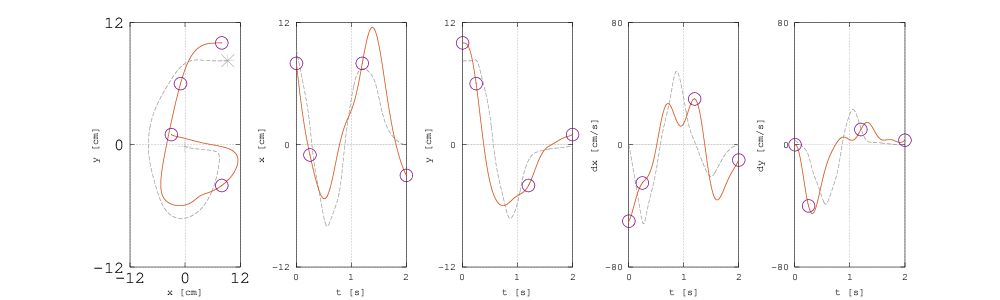

In [33]:
value=[0.5 0 0.5]; 
curveValue=mycolors.o; 

%figure('units','normalized','outerposition',[0 0 1 1],'Position', [0.0465 0.1794 0.9535 0.2394])
figure('position',[0 0 1000 300],'color',[1 1 1]); 


%% plot px-py
subplot(1,5,1)
hold on
plot(gmr(1,:),gmr(2,:),'--','color',mycolors.gy,'linewidth',1.5);
hold on
plot(kmp(1,:),kmp(2,:),'color',curveValue,'linewidth',2);
hold on
plot(gmr(1,1),gmr(2,1),'*','markersize',12,'color',mycolors.gy);
hold on
plot(gmr(1,end),gmr(2,end),'+','markersize',12,'color',mycolors.gy);

for viaIndex=1:viaNum
    if viaFlag(viaIndex)==1   
         plot(via_point(1,viaIndex),via_point(2,viaIndex),'o','color',value,'markersize',12,'linewidth',1.5); 
    end
end

box on
xlim([-12 12])
ylim([-12 12])
xlabel('x [cm]');
ylabel('y [cm]');
set(gca,'xtick',[-12 0 12]);
set(gca,'ytick',[-12 0 12]);
set(gca,'FontSize',17)
grid on
set(gca,'gridlinestyle','--')


%% plot t-px, t-py, t-vx and t-vy
for plotIndex=1:4
subplot(1,5,1+plotIndex)
hold on
plot([dt:dt:dt*len],gmr(plotIndex,:),'--','color',mycolors.gy,'linewidth',1.5)
hold on
plot([dt:dt:dt*len],kmp(plotIndex,:),'color',curveValue,'linewidth',2.0)

for viaIndex=1:viaNum
    if viaFlag(viaIndex)==1   
         plot(via_time(viaIndex),via_point(plotIndex,viaIndex),'o','color',value,'markersize',12,'linewidth',1.5); 
    end
end

box on
xlim([0 len*dt])
if plotIndex==1 || plotIndex==2 
    if plotIndex==1
       ylabel('x [cm]');
    end
    if plotIndex==2
       ylabel('y [cm]');
    end  
    ylim([-12 12])
    set(gca,'ytick',[-12 0 12]);
end
if plotIndex==3 || plotIndex==4 
    if plotIndex==3
       ylabel('dx [cm/s]','interpreter','latex');
    end
    if plotIndex==4
       ylabel('dy [cm/s]','interpreter','latex');
    end
    ylim([-80 80])
    set(gca,'ytick',[-80 0 80]);
end
xlabel('t [s]');
set(gca,'xtick',[0 1 2]);

set(gca,'FontSize',10)
grid on
set(gca,'gridlinestyle','--')
end